# BL 일간 리밸런싱 백테스트
- 기존 Ridge + Black-Litterman 코드를 재활용
- 일별 리밸런싱 포트폴리오 성과(샤프, MDD)와 시각화


In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# =========================
# Config
# =========================
# Paths
EMBEDDING_PATH = "data/kospidaq_embeddings_OpenAI.xlsx"
RETURN_PATH    = "data/report_return_mapping.xlsx"
ADJ_CLOSE_PATH = "data/adj_close_wide_2014_2026.xlsx"
MCAP_PATH      = "data/market_cap_2014_2025.xlsx"
KOSPI_PATH     = "data/kospi_krx_20190102_20251230.xlsx"
RISK_FREE_PATH = "data/treasury3m_proxy_krx_20130102_20251230.xlsx"

# Core dates
DATA_START_DATE = "2014-01-02"

# Core return settings
# Raw report return in mapping file (usually log_return_1)
RAW_TARGET_RETURN_COL = "log_return_1"
# Model/BL target in this notebook
TARGET_RETURN_COL = "log_return_1"
RETURN_COLS = [RAW_TARGET_RETURN_COL]
BACKTEST_RETURN_COL = "simple_return_1"

# Unified rolling window
WINDOW = 504

# Ridge settings
RIDGE_ALPHA = 100.0
MIN_TRAIN_SAMPLES = 2000
RUN_ALPHA_SEARCH = False
ALPHA_GRID = [0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]
ALPHA_SELECTION_METRIC = "oos_mse_global"  # or "oos_mse_daily_mean"

# Preprocess settings
MIN_REPORT_COUNT = 10
WINSOR_LOWER_Q = 0.01
WINSOR_UPPER_Q = 0.99

# Risk settings
RISK_AVERSION = 2.5
RISK_FREE_TRADING_DAYS = 252
OMEGA_MIN_OBS = 60
OMEGA_FALLBACK_MSE = 1e-4
OMEGA_WARMUP_DAYS = 0

# BL / portfolio settings
MIN_COVERAGE = 0.95
TAU = 0.02 # None -> 1 / n
LONG_ONLY = True
WEIGHT_CLIP = None  # e.g. 0.05

# Backtest settings
TRANSACTION_COST_BPS = 0.0      # buy/sell commission (bps)
SELL_TAX_BPS = 0.0              # sell-side tax (bps)

ANNUALIZATION = 252

## 데이터 로드


In [4]:
df_embed = pd.read_excel(EMBEDDING_PATH)
df_ret = pd.read_excel(RETURN_PATH)

print(df_embed.shape)
print(df_ret.shape)

(62450, 1538)
(62450, 14)


## 컬럼 선택 및 집계


In [5]:
from IPython.display import display

embedding_cols = [c for c in df_embed.columns if c.startswith("embedding_")]

df = pd.concat(
    [
        df_embed[["date", "ticker"] + embedding_cols],
        df_ret[["ticker_code"] + RETURN_COLS],
    ],
    axis=1
)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["ticker_code"] = pd.to_numeric(df["ticker_code"], errors="coerce")
raw_col = RAW_TARGET_RETURN_COL
df[raw_col] = pd.to_numeric(df[raw_col], errors="coerce")

df = df.dropna(subset=["date", "ticker_code", raw_col]).copy()
df["ticker_code"] = df["ticker_code"].astype(int).astype(str).str.zfill(6)

# 1) Daily cumulative MIN_REPORT_COUNT universe on full history (before dedup)
# Count reports per (ticker, date), then cumulative by date.
daily_report_count = (
    df.groupby(["ticker_code", "date"], as_index=False)
      .size()
      .rename(columns={"size": "n_reports_day"})
      .sort_values(["ticker_code", "date"])
)
daily_report_count["cum_reports"] = daily_report_count.groupby("ticker_code")["n_reports_day"].cumsum()

ticker_eligible_from = (
    daily_report_count[daily_report_count["cum_reports"] >= MIN_REPORT_COUNT]
    .groupby("ticker_code")["date"]
    .min()
    .sort_index()
)

# Keep for compatibility (tickers that eventually satisfy threshold)
base_universe = sorted(ticker_eligible_from.index.tolist())

df["eligible_from"] = df["ticker_code"].map(ticker_eligible_from)
df = df[df["eligible_from"].notna() & (df["date"] >= df["eligible_from"])].copy()

# 2) Winsorize RAW_TARGET_RETURN_COL on full eligible history
lo = df[raw_col].quantile(WINSOR_LOWER_Q)
hi = df[raw_col].quantile(WINSOR_UPPER_Q)
df[raw_col] = df[raw_col].clip(lower=lo, upper=hi)

# 3) Convert winsorized raw return to simple return, then excess simple return
if raw_col.startswith("log_return_"):
    df["simple_return_raw"] = np.expm1(df[raw_col])
elif raw_col.startswith("simple_return_"):
    df["simple_return_raw"] = df[raw_col]
else:
    raise ValueError("RAW_TARGET_RETURN_COL must be log_return_k or simple_return_k")

rf_tmp = pd.read_excel(RISK_FREE_PATH, index_col=0)
rf_tmp.index = pd.to_datetime(rf_tmp.index)
rf_tmp = rf_tmp.sort_index()
rf_col_tmp = "yield_3m_proxy" if "yield_3m_proxy" in rf_tmp.columns else rf_tmp.columns[0]
rf_daily_series = (pd.to_numeric(rf_tmp[rf_col_tmp], errors="coerce") / 100.0 / RISK_FREE_TRADING_DAYS).sort_index()

df = df.sort_values("date").copy()
df["rf_daily"] = rf_daily_series.reindex(pd.DatetimeIndex(df["date"]), method="ffill").to_numpy()
df["excess_simple_from_log"] = df["simple_return_raw"] - df["rf_daily"]

# 4) Remove same (date, ticker) duplicates by aggregation (after winsorize/universe)
agg_dict = {c: "mean" for c in embedding_cols}
agg_dict[TARGET_RETURN_COL] = "mean"
df_agg = (
    df.groupby(["date", "ticker_code"], as_index=False)
      .agg(agg_dict)
)

df_base = df_agg.dropna(subset=[TARGET_RETURN_COL]).copy()

# 5) Modeling window starts at DATA_START_DATE
data_start = pd.to_datetime(DATA_START_DATE)
df_model = df_base[df_base["date"] >= data_start].copy()

# Simple outputs
monthly_report_counts = (
    df_model
    .assign(month=df_model["date"].dt.to_period("M").astype(str))
    .groupby("month")
    .size()
    .rename("reports")
    .to_frame()
)

survived_reports = len(df_model)

display(df_model.head())
print(f"survived_reports: {survived_reports}")
display(monthly_report_counts)

,date,ticker_code,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536,log_return_1
0,2014-01-27,005930,-0.004234,-0.026621,0.011677,-0.029031,-0.026773,0.002997,-0.023707,0.004402,...,-0.026968,0.034166,0.006470,0.010703,0.004519,-0.018231,0.010394,0.007153,0.016981,-0.006990
1,2014-01-29,005930,-0.020431,-0.024610,0.029096,-0.020697,-0.006811,-0.002709,-0.041527,-0.012478,...,-0.011939,0.032876,0.007334,0.004060,-0.000864,-0.017649,0.004592,0.012179,0.031545,-0.006270
2,2014-01-29,009150,-0.012401,-0.020671,0.015240,-0.027071,-0.014091,-0.006828,-0.022362,-0.004302,...,-0.010850,0.038384,-0.001658,0.015321,0.007667,-0.018498,0.005128,0.000202,0.009418,-0.022745
3,2014-02-03,009150,-0.004266,-0.031415,0.031468,-0.025630,-0.023627,-0.000370,-0.025657,0.008038,...,-0.011768,0.038716,0.006885,0.000965,-0.000798,-0.006833,0.011609,0.012835,0.016999,-0.035913
4,2014-02-10,011070,0.015318,-0.027195,0.015801,-0.019660,-0.013728,0.006747,-0.014445,0.006235,...,0.001925,0.037077,-0.003970,0.007724,0.017704,0.000643,-0.002324,0.006300,0.007470,0.004566


survived_reports: 27796


,reports
month,
2014-01,3
2014-02,9
2014-03,29
2014-04,55
2014-05,58
...,...
2025-08,464
2025-09,278
2025-10,462


## Ridge Expanding-Window Prediction

In [6]:
def run_ridge_expanding_predict(
    df,
    embedding_cols,
    target_return,
    min_train_dates=252,
    alpha=10.0,
    min_train_samples=500,
):
    """
    For each date t, train Ridge on all past dates up to t-1 (expanding window) and predict on date t.
    """
    df_tmp = df.dropna(subset=[target_return]).copy()
    df_tmp["date"] = pd.to_datetime(df_tmp["date"])
    df_tmp["ticker_code"] = df_tmp["ticker_code"].astype(str).str.zfill(6)
    df_tmp = df_tmp.sort_values(["date", "ticker_code"]).reset_index(drop=True)

    unique_dates = pd.DatetimeIndex(sorted(df_tmp["date"].unique()))
    if len(unique_dates) <= min_train_dates:
        raise ValueError("Not enough dates for ridge expanding window.")

    pred_blocks = []

    for i in tqdm(range(min_train_dates, len(unique_dates)), desc="Ridge expanding", total=len(unique_dates) - min_train_dates):
        pred_date = unique_dates[i]
        train_dates = unique_dates[:i]

        train_mask = df_tmp["date"].isin(train_dates)
        test_mask = df_tmp["date"] == pred_date

        train_block = df_tmp.loc[train_mask].dropna(subset=embedding_cols + [target_return])
        test_block = df_tmp.loc[test_mask].dropna(subset=embedding_cols)

        if len(train_block) < min_train_samples or len(test_block) == 0:
            continue

        X_train = train_block[embedding_cols].values
        y_train = train_block[target_return].values
        X_test = test_block[embedding_cols].values

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha)),
        ])
        model.fit(X_train, y_train)

        pred_block = test_block[["date", "ticker_code", target_return]].copy()
        pred_block["pred_return"] = model.predict(X_test)
        pred_blocks.append(pred_block)

    if len(pred_blocks) == 0:
        return pd.DataFrame(columns=["date", "ticker_code", target_return, "pred_return"])

    return pd.concat(pred_blocks, ignore_index=True)

In [99]:
# Optional: Ridge alpha grid search on expanding OOS MSE
ridge_alpha_used = float(RIDGE_ALPHA)
alpha_search_result = pd.DataFrame()


def evaluate_ridge_alpha_grid(
    df,
    embedding_cols,
    target_return,
    min_train_dates,
    min_train_samples,
    alpha_grid,
):
    rows = []

    for a in tqdm(alpha_grid, desc="Alpha search", total=len(alpha_grid)):
        pred = run_ridge_expanding_predict(
            df=df,
            embedding_cols=embedding_cols,
            target_return=target_return,
            min_train_dates=min_train_dates,
            alpha=float(a),
            min_train_samples=min_train_samples,
        )

        valid = pred.dropna(subset=[target_return, "pred_return"]).copy()
        if len(valid) == 0:
            continue

        se = (valid[target_return].astype(float) - valid["pred_return"].astype(float)) ** 2
        mse_global = float(se.mean())
        mse_daily_mean = float(valid.assign(se=se).groupby("date")["se"].mean().mean())

        rows.append({
            "alpha": float(a),
            "oos_mse_global": mse_global,
            "oos_mse_daily_mean": mse_daily_mean,
            "pred_rows": int(len(valid)),
            "pred_dates": int(valid["date"].nunique()),
        })

    if len(rows) == 0:
        return pd.DataFrame(columns=["alpha", "oos_mse_global", "oos_mse_daily_mean", "pred_rows", "pred_dates"])

    out = pd.DataFrame(rows).sort_values(["oos_mse_global", "alpha"]).reset_index(drop=True)
    return out


if RUN_ALPHA_SEARCH:
    alpha_search_result = evaluate_ridge_alpha_grid(
        df=df_model,
        embedding_cols=embedding_cols,
        target_return=TARGET_RETURN_COL,
        min_train_dates=WINDOW,
        min_train_samples=MIN_TRAIN_SAMPLES,
        alpha_grid=list(ALPHA_GRID),
    )

    if alpha_search_result.empty:
        print("alpha search produced no valid predictions. fallback to RIDGE_ALPHA.")
    else:
        metric = str(ALPHA_SELECTION_METRIC)
        if metric not in ["oos_mse_global", "oos_mse_daily_mean"]:
            metric = "oos_mse_global"

        ridge_alpha_used = float(alpha_search_result.sort_values([metric, "alpha"]).iloc[0]["alpha"])
        print(f"selected alpha={ridge_alpha_used} by {metric}")
        display(alpha_search_result)
else:
    print(f"RUN_ALPHA_SEARCH=False -> using RIDGE_ALPHA={ridge_alpha_used}")


RUN_ALPHA_SEARCH=False -> using RIDGE_ALPHA=10.0


## Ridge Alpha-vs-MSE Diagnostics


Alpha diagnostics:   0%|          | 0/7 [00:00<?, ?it/s]

Ridge expanding:   0%|          | 0/2370 [00:00<?, ?it/s]

Ridge expanding:   0%|          | 0/2370 [00:00<?, ?it/s]

Ridge expanding:   0%|          | 0/2370 [00:00<?, ?it/s]

Ridge expanding:   0%|          | 0/2370 [00:00<?, ?it/s]

Ridge expanding:   0%|          | 0/2370 [00:00<?, ?it/s]

Ridge expanding:   0%|          | 0/2370 [00:00<?, ?it/s]

Ridge expanding:   0%|          | 0/2370 [00:00<?, ?it/s]

,alpha,oos_mse_global,oos_r2_global,oos_mse_daily_mean,oos_mse_daily_median,oos_r2_daily_mean,oos_r2_daily_median,pred_rows,pred_dates
0,0.1,0.000886,-0.171665,0.000887,0.000641,-9.643602,-0.662492,25359,2370
1,0.3,0.000885,-0.170855,0.000886,0.000640,-9.606100,-0.663191,25359,2370
2,1.0,0.000883,-0.168262,0.000883,0.000639,-9.594048,-0.659750,25359,2370
3,3.0,0.000879,-0.162262,0.000876,0.000633,-9.610134,-0.648611,25359,2370
4,10.0,0.000869,-0.148788,0.000860,0.000623,-9.763875,-0.634237,25359,2370
5,30.0,0.000854,-0.129154,0.000837,0.000605,-10.378688,-0.589839,25359,2370
6,100.0,0.000833,-0.101322,0.000806,0.000569,-12.210302,-0.534802,25359,2370


best alpha by global MSE: 100.0
best alpha by global R2 : 100.0


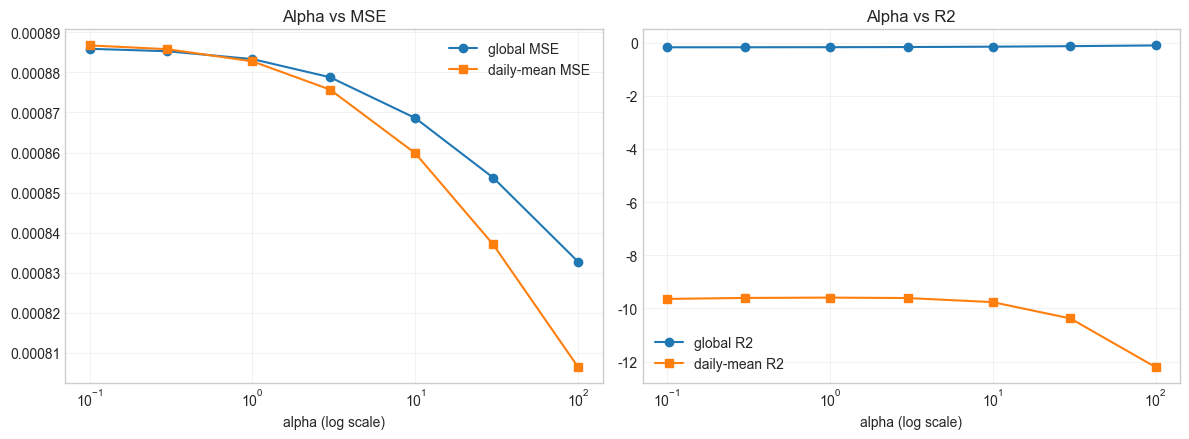

In [110]:
# Alpha-wise OOS diagnostics (MSE + R^2)
from sklearn.metrics import r2_score

ALPHA_MSE_GRID = list(ALPHA_GRID) if "ALPHA_GRID" in globals() else [0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

if "run_ridge_expanding_predict" not in globals():
    raise ValueError("run_ridge_expanding_predict is not defined. Run Ridge cells first.")

alpha_daily_rows = []
alpha_summary_rows = []

for a in tqdm(ALPHA_MSE_GRID, desc="Alpha diagnostics", total=len(ALPHA_MSE_GRID)):
    pred = run_ridge_expanding_predict(
        df=df_model,
        embedding_cols=embedding_cols,
        target_return=TARGET_RETURN_COL,
        min_train_dates=WINDOW,
        alpha=float(a),
        min_train_samples=MIN_TRAIN_SAMPLES,
    )

    valid = pred.dropna(subset=[TARGET_RETURN_COL, "pred_return"]).copy()
    if valid.empty:
        continue

    y = valid[TARGET_RETURN_COL].astype(float)
    yhat = valid["pred_return"].astype(float)
    se = (y - yhat) ** 2

    # global metrics
    mse_global = float(se.mean())
    if y.nunique() <= 1:
        r2_global = np.nan
    else:
        r2_global = float(r2_score(y, yhat))

    # daily metrics
    daily = valid[["date", TARGET_RETURN_COL, "pred_return"]].copy()
    daily["se"] = se.values

    daily_rows = []
    for d, g in daily.groupby("date"):
        n = len(g)
        mse_d = float(g["se"].mean())

        y_d = g[TARGET_RETURN_COL].astype(float).values
        yhat_d = g["pred_return"].astype(float).values
        if n < 2 or np.nanstd(y_d) == 0:
            r2_d = np.nan
        else:
            r2_d = float(r2_score(y_d, yhat_d))

        daily_rows.append({
            "alpha": float(a),
            "date": pd.to_datetime(d),
            "n_pred": int(n),
            "mse_day": mse_d,
            "r2_day": r2_d,
        })

    daily_df = pd.DataFrame(daily_rows).sort_values("date")
    alpha_daily_rows.append(daily_df)

    alpha_summary_rows.append({
        "alpha": float(a),
        "oos_mse_global": mse_global,
        "oos_r2_global": r2_global,
        "oos_mse_daily_mean": float(daily_df["mse_day"].mean()),
        "oos_mse_daily_median": float(daily_df["mse_day"].median()),
        "oos_r2_daily_mean": float(daily_df["r2_day"].mean(skipna=True)),
        "oos_r2_daily_median": float(daily_df["r2_day"].median(skipna=True)),
        "pred_rows": int(len(valid)),
        "pred_dates": int(valid["date"].nunique()),
    })

alpha_daily_metrics = (
    pd.concat(alpha_daily_rows, ignore_index=True)
    if len(alpha_daily_rows) > 0 else pd.DataFrame(columns=["alpha", "date", "n_pred", "mse_day", "r2_day"])
)

alpha_summary = (
    pd.DataFrame(alpha_summary_rows).sort_values("alpha").reset_index(drop=True)
    if len(alpha_summary_rows) > 0 else pd.DataFrame()
)

if alpha_summary.empty:
    print("No valid alpha results.")
else:
    display(alpha_summary)
    print("best alpha by global MSE:", float(alpha_summary.loc[alpha_summary["oos_mse_global"].idxmin(), "alpha"]))
    print("best alpha by global R2 :", float(alpha_summary.loc[alpha_summary["oos_r2_global"].idxmax(), "alpha"]))

    # alpha vs summary plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

    axes[0].plot(alpha_summary["alpha"], alpha_summary["oos_mse_global"], marker="o", label="global MSE")
    axes[0].plot(alpha_summary["alpha"], alpha_summary["oos_mse_daily_mean"], marker="s", label="daily-mean MSE")
    axes[0].set_xscale("log")
    axes[0].set_title("Alpha vs MSE")
    axes[0].set_xlabel("alpha (log scale)")
    axes[0].grid(alpha=0.25)
    axes[0].legend()

    axes[1].plot(alpha_summary["alpha"], alpha_summary["oos_r2_global"], marker="o", label="global R2")
    axes[1].plot(alpha_summary["alpha"], alpha_summary["oos_r2_daily_mean"], marker="s", label="daily-mean R2")
    axes[1].set_xscale("log")
    axes[1].set_title("Alpha vs R2")
    axes[1].set_xlabel("alpha (log scale)")
    axes[1].grid(alpha=0.25)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# 필요하면 특정 alpha의 일별 metric 확인:
# display(alpha_daily_metrics[alpha_daily_metrics["alpha"] == 10.0].head(20))


In [7]:
alpha_to_use = float(globals().get("ridge_alpha_used", RIDGE_ALPHA))

df_pred = run_ridge_expanding_predict(
    df=df_model,
    embedding_cols=embedding_cols,
    target_return=TARGET_RETURN_COL,
    min_train_dates=WINDOW,
    alpha=alpha_to_use,
    min_train_samples=MIN_TRAIN_SAMPLES,
)

df_view = (
    df_pred
    .groupby(["date", "ticker_code"], as_index=False)
    .agg({"pred_return": "mean"})
)

expanding_summary = pd.Series({
    "target_return_col": TARGET_RETURN_COL,
    "train_mode": "expanding",
    "min_train_dates": WINDOW,
    "ridge_alpha_config": RIDGE_ALPHA,
    "ridge_alpha_used": alpha_to_use,
    "pred_rows": len(df_pred),
    "pred_dates": df_pred["date"].nunique() if not df_pred.empty else 0,
})

print(expanding_summary.to_string())

df_view.head()

Ridge expanding:   0%|          | 0/2370 [00:00<?, ?it/s]

target_return_col     log_return_1
train_mode               expanding
min_train_dates                504
ridge_alpha_config           100.0
ridge_alpha_used             100.0
pred_rows                    25359
pred_dates                    2370


,date,ticker_code,pred_return
0,2016-03-31,000660,-0.024298
1,2016-03-31,003550,-0.006454
2,2016-03-31,006800,0.001789
3,2016-03-31,011790,-0.013463
4,2016-03-31,035250,-0.018697


## 가격/시총 로드


In [8]:
from pathlib import Path

ADJ_CLOSE_PATH = Path(ADJ_CLOSE_PATH)
MCAP_PATH      = Path(MCAP_PATH)

px = pd.read_excel(ADJ_CLOSE_PATH, index_col=0)
mc = pd.read_excel(MCAP_PATH, index_col=0)

px.index = pd.to_datetime(px.index)
mc.index = pd.to_datetime(mc.index)

# ticker_code를 문자열로 통일(005930 같은)
px.columns = px.columns.astype(str).str.zfill(6)
mc.columns = mc.columns.astype(str).str.zfill(6)

px = px.sort_index()
mc = mc.sort_index()

(px.shape, mc.shape, px.index.min(), px.index.max(), mc.index.max())


((2951, 2761),
 (2945, 2761),
 Timestamp('2014-01-02 00:00:00'),
 Timestamp('2026-01-09 00:00:00'),
 Timestamp('2025-12-30 00:00:00'))

## Risk Aversion and BL Functions

In [18]:
# Date-mapped daily risk aversion from KOSPI excess returns

def _pick_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

kospi_path = Path(KOSPI_PATH)
rf_path = Path(RISK_FREE_PATH)

if not kospi_path.exists():
    raise FileNotFoundError(f"KOSPI_PATH not found: {kospi_path}")
if not rf_path.exists():
    raise FileNotFoundError(f"RISK_FREE_PATH not found: {rf_path}")

df_kospi = pd.read_excel(kospi_path, index_col=0)
df_rf = pd.read_excel(rf_path, index_col=0)

df_kospi.index = pd.to_datetime(df_kospi.index)
df_rf.index = pd.to_datetime(df_rf.index)
df_kospi = df_kospi.sort_index()
df_rf = df_rf.sort_index()

mkt_col = _pick_col(["close", "CLSPRC_IDX"], list(df_kospi.columns))
if mkt_col is None:
    raise ValueError("Cannot find market close column in KOSPI data.")

rf_col = "yield_3m_proxy" if "yield_3m_proxy" in df_rf.columns else df_rf.columns[0]

mkt_ret = df_kospi[mkt_col].astype(float).pct_change().rename("mkt_ret")
rf_daily = (pd.to_numeric(df_rf[rf_col], errors="coerce") / 100.0 / RISK_FREE_TRADING_DAYS).rename("rf_daily")
RF_DAILY_SERIES = rf_daily.sort_index().copy()

# Align by date (inner join) for different lengths/missing days
risk_df = pd.concat([mkt_ret, rf_daily], axis=1, join="inner").dropna()

if len(risk_df) == 0:
    raise ValueError("No aligned rows between KOSPI and risk-free series.")

risk_df["excess_ret"] = risk_df["mkt_ret"] - risk_df["rf_daily"]

RISK_AVERSION_USED = float(RISK_AVERSION)

risk_aversion_summary = pd.Series({
    "risk_aversion": RISK_AVERSION,
    "window": WINDOW,
    "samples": len(risk_df),
    "risk_aversion_used": RISK_AVERSION_USED,
    "market_col": mkt_col,
    "risk_free_col": rf_col,
})

def compute_simple_returns(price_wide: pd.DataFrame) -> pd.DataFrame:
    return price_wide.pct_change()

from sklearn.covariance import LedoitWolf

def compute_prior_at_date(
    view_date: pd.Timestamp,
    px_wide: pd.DataFrame,
    mc_wide: pd.DataFrame,
    window: int = 252,
    min_coverage: float = 0.90,
    risk_aversion: float = 2.5,
    ret_wide: pd.DataFrame = None,
    universe_filter: list = None,
    rf_daily_series: pd.Series = None
):
    """
    Returns:
      - tickers_univ: prior에 포함되는 종목 리스트 (정렬된 순서)
      - Sigma: (N,N) 공분산 (Ledoit-Wolf)
      - Pi: (N,) 내재 기대수익률
      - w_mkt: (N,) 시총가중치
    """
    view_date = pd.to_datetime(view_date)

    # 시총 데이터 끝나는 날짜 체크
    if view_date not in mc_wide.index:
        raise ValueError(f"market cap에 {view_date.date()}가 없습니다. (mc max={mc_wide.index.max().date()})")

    # 수익률 계산 (외부에서 미리 계산한 경우 재사용)
    if ret_wide is None:
        ret = compute_simple_returns(px_wide)
    else:
        ret = ret_wide

    # view_date 기준, 직전 window일 수익률 구간 뽑기
    if view_date not in ret.index:
        raise ValueError(f"가격/수익률 데이터에 {view_date.date()}가 없습니다.")

    end_loc = ret.index.get_loc(view_date)
    start_loc = end_loc - window + 1
    if start_loc < 0:
        raise ValueError("윈도우가 너무 깁니다. 과거 데이터가 부족합니다.")

    ret_win = ret.iloc[start_loc:end_loc+1]  # (window, #tickers)

    # Optional: convert to excess simple returns
    if rf_daily_series is not None:
        rf_win = rf_daily_series.reindex(ret_win.index).ffill()
        ret_win = ret_win.sub(rf_win, axis=0)

    # 커버리지 조건 (유효 관측치 비율)
    min_obs = int(np.ceil(window * min_coverage))
    valid_obs = ret_win.notna().sum(axis=0)
    tickers_cov = valid_obs[valid_obs >= min_obs].index

    # 당일 시총 존재 종목
    mcap_t = mc_wide.loc[view_date]
    tickers_mcap = mcap_t.dropna().index

    # 최종 prior 유니버스
    if universe_filter is not None:
        universe_filter = set(universe_filter)
        tickers_cov = [t for t in tickers_cov if t in universe_filter]
        tickers_mcap = [t for t in tickers_mcap if t in universe_filter]

    tickers_univ = sorted(list(set(tickers_cov).intersection(set(tickers_mcap))))
    if len(tickers_univ) < 2:
        raise ValueError("prior 유니버스가 너무 작습니다. (커버리지/시총 결측 확인)")

    # 공분산: 수익률 윈도우에서 유니버스만 뽑고, 결측은 행 단위로 제거
    X = ret_win[tickers_univ]
    X = X.dropna(axis=0, how="any")  # LedoitWolf는 NaN 허용 안 함

    if len(X) < min_obs:
        # dropna로 너무 줄어들면(공통 거래일 부족) 기준을 더 느슨하게 하거나 다른 처리 필요
        raise ValueError(f"공통 관측치가 부족합니다: {len(X)}행만 남음 (min_obs={min_obs})")

    lw = LedoitWolf().fit(X.values)
    Sigma = lw.covariance_

    # 시총가중치
    mcap_vec = mc_wide.loc[view_date, tickers_univ].values.astype(float)
    w_mkt = mcap_vec / np.nansum(mcap_vec)

    # 내재 기대수익률
    Pi = risk_aversion * (Sigma @ w_mkt)

    return tickers_univ, Sigma, Pi, w_mkt


def align_view_to_prior(
    df_view: pd.DataFrame,      # columns: date, ticker_code, pred_return
    view_date: pd.Timestamp,
    tickers_univ: list,
    df_view_by_date: dict = None
):
    view_date = pd.to_datetime(view_date)

    if df_view_by_date is not None:
        tmp = df_view_by_date.get(view_date)
        if tmp is None:
            raise ValueError(f"view에 {view_date.date()}가 없습니다.")
        tmp = tmp.copy()
    else:
        tmp = df_view[df_view["date"] == view_date].copy()

    tmp["ticker_code"] = tmp["ticker_code"].astype(str).str.zfill(6)

    view_tickers_all = set(tmp["ticker_code"].unique())
    prior_tickers = set(tickers_univ)

    # prior 기준으로 view 필터
    tmp = tmp[tmp["ticker_code"].isin(prior_tickers)]

    view_tickers = sorted(tmp["ticker_code"].unique())
    missing_in_prior = sorted(list(view_tickers_all - prior_tickers))
    missing_in_view  = sorted(list(prior_tickers - set(view_tickers)))

    if len(view_tickers) < 1:
        raise ValueError("교집합 종목이 없습니다. (view/prior 정합성 문제)")

    # view 순서로 Q 만들기
    tmp_c = tmp.sort_values("ticker_code")
    Q = tmp_c["pred_return"].values
    tickers_view = tmp_c["ticker_code"].values

    return {
        "tickers_view": tickers_view,
        "Q": Q,
        "missing_in_prior": missing_in_prior,  # view는 있는데 prior에 없는 종목
        "missing_in_view": missing_in_view,    # prior는 있는데 view가 없는 종목
        "n_view": len(view_tickers),
        "n_prior": len(prior_tickers),
        "n_common": len(view_tickers),
    }


def slice_prior_to_common(tickers_univ, Sigma, Pi, w_mkt, tickers_common):
    # tickers_common: array-like of ticker codes (sorted)
    idx_map = {t:i for i,t in enumerate(tickers_univ)}
    idx = np.array([idx_map[t] for t in tickers_common], dtype=int)

    Sigma_c = Sigma[np.ix_(idx, idx)]
    Pi_c = Pi[idx]
    w_c = w_mkt[idx]

    return Sigma_c, Pi_c, w_c


def compute_oos_mse_for_omega(df_pred, target_return, start_date=None):
    mask = df_pred["pred_return"].notna() & df_pred[target_return].notna()
    if start_date is not None:
        mask &= df_pred["date"] >= pd.to_datetime(start_date)

    y_true = df_pred.loc[mask, target_return].values
    y_pred = df_pred.loc[mask, "pred_return"].values

    if len(y_true) == 0:
        raise ValueError("No valid rows to compute OOS MSE for Omega.")

    return mean_squared_error(y_true, y_pred)


def black_litterman_posterior(Pi, Sigma, P, Q, Omega, tau=0.05):
    Sigma_t = tau * Sigma

    A = np.linalg.inv(Sigma_t) + P.T @ np.linalg.inv(Omega) @ P
    b = np.linalg.inv(Sigma_t) @ Pi + P.T @ np.linalg.inv(Omega) @ Q

    mu_bl = np.linalg.solve(A, b)  # inv(A)@b 보다 안정적
    return mu_bl


def compute_bl_weights(mu_bl, Sigma, risk_aversion, long_only=True, weight_clip=None):
    # 블랙-리터만 기대수익률을 평균-분산 가중치로 변환
    w = np.linalg.solve(Sigma, mu_bl) / risk_aversion

    if long_only:
        w = np.clip(w, 0.0, None)

    if weight_clip is not None:
        if long_only:
            w = np.clip(w, 0.0, weight_clip)
        else:
            w = np.clip(w, -weight_clip, weight_clip)

    s = w.sum()
    if np.isclose(s, 0):
        w = np.ones_like(w) / len(w)
    else:
        w = w / s

    return w


def calc_mdd(cum):
    roll_max = np.maximum.accumulate(cum)
    dd = cum / roll_max - 1.0
    return dd.min(), dd

## 일간 리밸런싱 백테스트


In [19]:
# Returns for BL prior (simple)
ret_simple = compute_simple_returns(px)

# Backtest return series from price data (converted to simple excess return)
ret_col = BACKTEST_RETURN_COL
if ret_col.startswith("log_return_"):
    horizon = int(ret_col.split("_")[-1])
    if horizon < 1:
        raise ValueError("BACKTEST_RETURN_COL horizon must be >= 1")
    ret_simple_wide = np.expm1(np.log(px / px.shift(horizon)))
elif ret_col.startswith("simple_return_"):
    horizon = int(ret_col.split("_")[-1])
    if horizon < 1:
        raise ValueError("BACKTEST_RETURN_COL horizon must be >= 1")
    ret_simple_wide = px.pct_change(periods=horizon)
else:
    raise ValueError("BACKTEST_RETURN_COL must be log_return_k or simple_return_k")

# Risk-free for same horizon, then convert to excess simple returns
rf_daily_bt = RF_DAILY_SERIES.reindex(ret_simple_wide.index).ffill()
if horizon == 1:
    rf_period = rf_daily_bt
else:
    rf_period = (1.0 + rf_daily_bt).rolling(horizon).apply(np.prod, raw=True) - 1.0

ret_wide = ret_simple_wide.sub(rf_period, axis=0)

# View cache
df_view_by_date = {pd.to_datetime(d): g for d, g in df_view.groupby("date")}

# Backtest date range (fixed by prediction availability)
all_view_dates = pd.to_datetime(df_view["date"].unique())
all_view_dates = pd.DatetimeIndex(all_view_dates).sort_values()

if len(all_view_dates) == 0:
    raise ValueError("No prediction dates available for backtest.")

if len(all_view_dates) <= int(OMEGA_WARMUP_DAYS):
    raise ValueError("Not enough prediction dates for requested OMEGA_WARMUP_DAYS.")

backtest_start = all_view_dates[int(OMEGA_WARMUP_DAYS)]
backtest_end = all_view_dates[-1]
view_dates = list(all_view_dates)

# Expanding daily forecast error stats for Omega
omega_day_sse = 0.0
omega_day_cnt = 0
omega_daily_hist = []

results = []
weights_hist = []

ret_index = ret_wide.index

prev_w = None
prev_tickers = None

if "ticker_eligible_from" in globals() and isinstance(ticker_eligible_from, pd.Series):
    eligible_from_series = ticker_eligible_from.sort_values()
else:
    eligible_from_series = pd.Series(dtype="datetime64[ns]")

for view_date in tqdm(view_dates, desc="Backtest", total=len(view_dates)):
    try:
        risk_aversion_t = float(RISK_AVERSION)

        if len(eligible_from_series) > 0:
            universe_filter_t = eligible_from_series.index[eligible_from_series <= pd.to_datetime(view_date)].tolist()
        else:
            universe_filter_t = None

        tickers_univ, Sigma, Pi, w_mkt = compute_prior_at_date(
            view_date=view_date,
            px_wide=px,
            mc_wide=mc,
            window=WINDOW,
            min_coverage=MIN_COVERAGE,
            risk_aversion=risk_aversion_t,
            ret_wide=ret_simple,
            universe_filter=universe_filter_t,
            rf_daily_series=RF_DAILY_SERIES
        )

        aligned = align_view_to_prior(
            df_view=df_view,
            view_date=view_date,
            tickers_univ=tickers_univ,
            df_view_by_date=df_view_by_date
        )

        Q_log = aligned["Q"].astype(float)
        rf_view = rf_period.asof(pd.to_datetime(view_date))
        if pd.isna(rf_view) or (not np.isfinite(rf_view)):
            rf_view = 0.0
        Q = np.expm1(Q_log) - float(rf_view)
        tickers_view = np.array(aligned["tickers_view"], dtype=str)

        n = len(tickers_univ)
        k = len(Q)
        idx_map = {t: i for i, t in enumerate(tickers_univ)}

        if k == 0:
            continue

        P = np.zeros((k, n))
        for i, t in enumerate(tickers_view):
            P[i, idx_map[t]] = 1.0

        tau = (1.0 / n) if TAU is None else TAU

        if omega_day_cnt >= int(OMEGA_MIN_OBS):
            omega_level = float(omega_day_sse / omega_day_cnt)
        else:
            omega_level = float(OMEGA_FALLBACK_MSE)

        if (not np.isfinite(omega_level)) or (omega_level <= 0):
            omega_level = float(OMEGA_FALLBACK_MSE)
        omega_level = max(float(omega_level), 1e-8)

        Omega = np.eye(k, dtype=float) * omega_level

        is_live = pd.to_datetime(view_date) >= pd.to_datetime(backtest_start)
        if not is_live:
            w = None
            w_bm = None
        else:
            mu_bl = black_litterman_posterior(
                Pi=Pi,
                Sigma=Sigma,
                P=P,
                Q=Q,
                Omega=Omega,
                tau=tau
            )

            w = compute_bl_weights(
                mu_bl=mu_bl,
                Sigma=Sigma,
                risk_aversion=risk_aversion_t,
                long_only=LONG_ONLY,
                weight_clip=WEIGHT_CLIP
            )

            # Benchmark: market-cap weight
            bm_sum = np.sum(w_mkt)
            if np.isclose(bm_sum, 0):
                w_bm = np.ones_like(w_mkt) / len(w_mkt)
            else:
                w_bm = w_mkt / bm_sum

    except Exception:
        continue

    if view_date not in ret_index:
        continue

    loc = ret_index.get_loc(view_date)
    if not isinstance(loc, (int, np.integer)):
        loc = loc.start

    ret_pos = loc + horizon
    if ret_pos >= len(ret_index):
        continue

    ret_date = ret_index[ret_pos]
    ret_vec = ret_wide.loc[ret_date, tickers_univ].values.astype(float)
    tickers_ret = np.array(tickers_univ, dtype=str)

    # Update expanding DAILY MSE after realized return is known (no look-ahead)
    ret_series = pd.Series(ret_vec, index=tickers_ret)
    pred_series = pd.Series(Q, index=tickers_view)
    common_tickers = pred_series.index.intersection(ret_series.index)

    if len(common_tickers) > 0:
        err = pred_series.loc[common_tickers].to_numpy(dtype=float) - ret_series.loc[common_tickers].to_numpy(dtype=float)
        valid_err = np.isfinite(err)
        if np.any(valid_err):
            mse_day = float(np.mean(np.square(err[valid_err])))
            omega_day_sse += mse_day
            omega_day_cnt += 1
            omega_daily_hist.append({
                "view_date": view_date,
                "ret_date": ret_date,
                "mse_day": mse_day,
                "n_common": int(np.sum(valid_err)),
                "omega_day_expanding": float(omega_day_sse / omega_day_cnt),
            })

    if pd.to_datetime(view_date) < pd.to_datetime(backtest_start):
        continue

    if np.isnan(ret_vec).any():
        mask = ~np.isnan(ret_vec)
        if mask.sum() < 2:
            continue
        ret_vec = ret_vec[mask]
        w = w[mask]
        w = w / w.sum()
        w_bm = w_bm[mask]
        w_bm = w_bm / w_bm.sum()
        tickers_ret = tickers_ret[mask]

    turnover = 0.0
    sell_turnover = 0.0
    if prev_w is None:
        turnover = np.sum(np.abs(w))
        sell_turnover = np.sum(w)
    else:
        if (prev_tickers is not None) and np.array_equal(prev_tickers, tickers_ret):
            delta_w = w - prev_w
            turnover = np.sum(np.abs(delta_w))
            sell_turnover = np.sum(np.clip(-delta_w, 0.0, None))
        else:
            turnover = np.sum(np.abs(w))
            sell_turnover = np.sum(w)

    cost = turnover * (TRANSACTION_COST_BPS / 10000.0) + sell_turnover * (SELL_TAX_BPS / 10000.0)

    port_ret = float(np.dot(w, ret_vec)) - cost
    bm_ret = float(np.dot(w_bm, ret_vec))

    results.append({
        "view_date": view_date,
        "next_date": ret_date,
        "net_ret": port_ret,
        "bm_ret": bm_ret,
        "cost": cost,
        "omega_used": omega_level,
        "n_assets": len(w)
    })

    weights_hist.append(
        pd.DataFrame({
            "date": view_date,
            "ticker_code": tickers_ret,
            "weight": w
        })
    )

    prev_w = w
    prev_tickers = tickers_ret

if len(results) == 0:
    df_bt = pd.DataFrame()
    weights_history = pd.DataFrame()
else:
    df_bt = pd.DataFrame(results).sort_values("next_date").set_index("next_date")
    weights_history = pd.concat(weights_hist, ignore_index=True)

df_bt


Backtest:   0%|          | 0/2370 [00:00<?, ?it/s]

,view_date,net_ret,bm_ret,cost,omega_used,n_assets
next_date,,,,,,
2016-04-01,2016-03-31,-0.007947,-0.011561,0.001700,0.000100,141
2016-04-04,2016-04-01,-0.014906,0.003652,0.001499,0.000100,141
2016-04-05,2016-04-04,0.004154,-0.010441,0.001458,0.000100,141
2016-04-06,2016-04-05,0.025481,0.004356,0.001705,0.000100,141
2016-04-07,2016-04-06,-0.001513,0.001021,0.001576,0.000100,141
...,...,...,...,...,...,...
2025-12-24,2025-12-23,-0.008153,-0.002293,0.001700,0.000811,625
2025-12-26,2025-12-24,0.002164,0.005768,0.000649,0.000811,625
2025-12-29,2025-12-26,0.014998,0.021924,0.000366,0.000811,625


## 성과 요약


In [20]:
if df_bt.empty:
    print("백테스트 결과가 없습니다. 날짜/데이터 범위를 확인하세요.")
else:
    def make_summary(ret_series, label):
        cum = (1.0 + ret_series).cumprod()
        mdd, dd = calc_mdd(cum.values)

        ret_std = ret_series.std()
        if ret_std == 0 or np.isnan(ret_std):
            sharpe = np.nan
        else:
            sharpe = (ret_series.mean() / ret_std) * np.sqrt(ANNUALIZATION)

        summary = pd.Series({
            "샤프지수": sharpe,
            "MDD": mdd,
            "누적수익률": cum.iloc[-1] - 1.0,
            "평균일간수익률": ret_series.mean(),
            "일간변동성": ret_std,
            "관측일수": len(ret_series)
        }, name=label)

        return summary, cum, dd

    summary_strat, cum, dd = make_summary(df_bt["net_ret"], "전략")
    df_bt["cum"] = cum
    df_bt["drawdown"] = dd

    if "bm_ret" in df_bt.columns:
        summary_bm, bm_cum, bm_dd = make_summary(df_bt["bm_ret"], "벤치마크")
        df_bt["bm_cum"] = bm_cum
        df_bt["bm_drawdown"] = bm_dd
        summary = pd.concat([summary_strat, summary_bm], axis=1)
    else:
        summary = summary_strat

summary

,전략,벤치마크
샤프지수,-0.206049,0.527132
MDD,-0.652143,-0.407541
누적수익률,-0.412332,1.095341
평균일간수익률,-0.000154,0.000377
일간변동성,0.011861,0.011351
관측일수,2368.000000,2368.000000


## 시각화


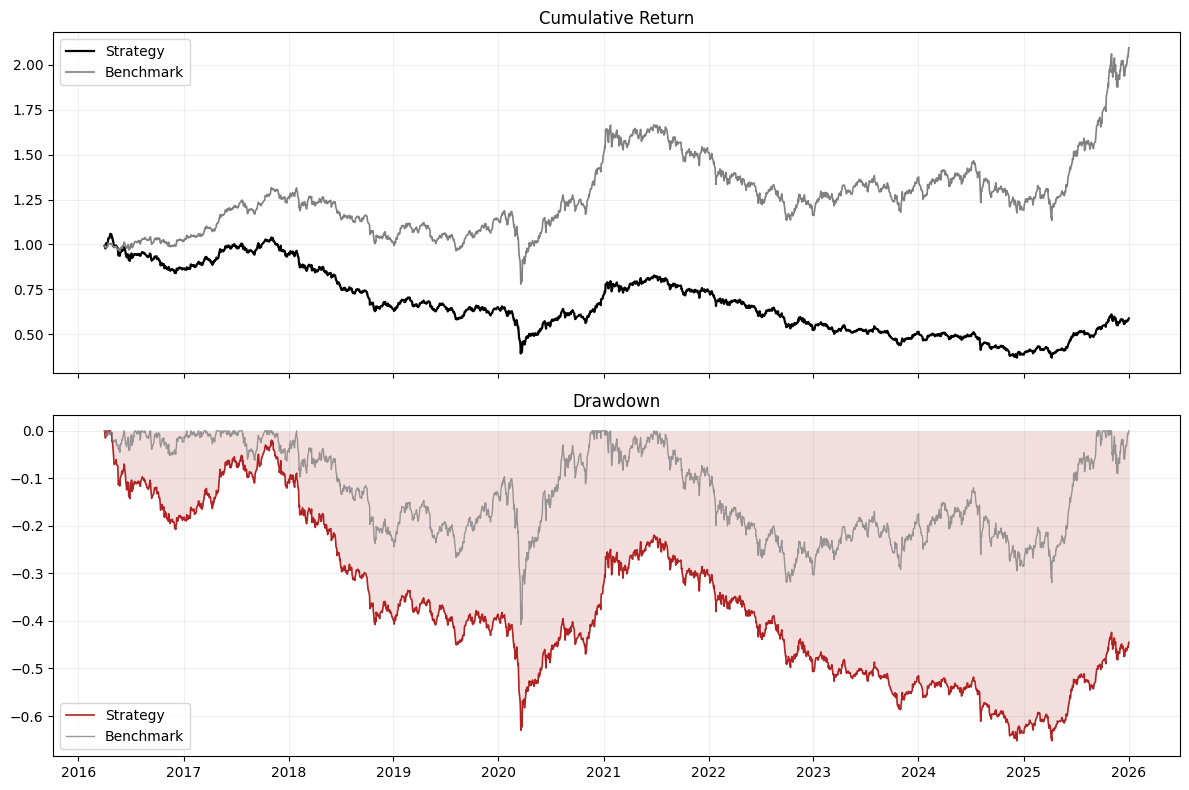

In [21]:
if df_bt.empty:
    print("No backtest results to plot.")
else:
    bt_plot = df_bt.copy()

    if "cum" not in bt_plot.columns or "drawdown" not in bt_plot.columns:
        bt_plot["cum"] = (1.0 + bt_plot["net_ret"]).cumprod()
        _, dd = calc_mdd(bt_plot["cum"].values)
        bt_plot["drawdown"] = dd

    if "bm_ret" in bt_plot.columns and ("bm_cum" not in bt_plot.columns or "bm_drawdown" not in bt_plot.columns):
        bt_plot["bm_cum"] = (1.0 + bt_plot["bm_ret"]).cumprod()
        _, bm_dd = calc_mdd(bt_plot["bm_cum"].values)
        bt_plot["bm_drawdown"] = bm_dd

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(bt_plot.index, bt_plot["cum"], color="black", lw=1.6, label="Strategy")
    if "bm_cum" in bt_plot.columns:
        axes[0].plot(bt_plot.index, bt_plot["bm_cum"], color="gray", lw=1.2, label="Benchmark")
    axes[0].set_title("Cumulative Return")
    axes[0].legend(loc="best")
    axes[0].grid(alpha=0.2)

    axes[1].plot(bt_plot.index, bt_plot["drawdown"], color="firebrick", lw=1.2, label="Strategy")
    axes[1].fill_between(bt_plot.index, bt_plot["drawdown"], 0, color="firebrick", alpha=0.15, linewidth=0)
    if "bm_drawdown" in bt_plot.columns:
        axes[1].plot(bt_plot.index, bt_plot["bm_drawdown"], color="gray", lw=1.0, alpha=0.8, label="Benchmark")
    axes[1].set_title("Drawdown")
    axes[1].legend(loc="best")
    axes[1].grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

## Rolling Multi-Benchmark Summary (2016~2025, ..., 2024~2025)


In [13]:
if df_bt.empty:
    print("No backtest results. Run backtest first.")
else:
    END_DATE_FIXED = pd.Timestamp("2025-12-30")
    START_YEARS = list(range(2016, 2025))
    BENCH_LONG_ONLY = True
    RP_MAX_ITER = 500
    RP_TOL = 1e-10

    def _normalize_weights(w):
        w = np.asarray(w, dtype=float)
        w = np.where(np.isfinite(w), w, 0.0)
        s = w.sum()
        if np.isclose(s, 0.0):
            return np.ones_like(w) / len(w)
        return w / s

    def min_variance_weights(Sigma, long_only=True):
        n = Sigma.shape[0]
        ones = np.ones(n)
        S = (Sigma + Sigma.T) / 2.0
        invS = np.linalg.pinv(S)
        w = invS @ ones
        if long_only:
            w = np.clip(w, 0.0, None)
        return _normalize_weights(w)

    def risk_parity_weights(Sigma, max_iter=500, tol=1e-10):
        n = Sigma.shape[0]
        S = (Sigma + Sigma.T) / 2.0
        w = np.ones(n) / n
        eps = 1e-12

        for _ in range(max_iter):
            mrc = S @ w
            rc = w * mrc
            total = rc.sum()
            if (not np.isfinite(total)) or (total <= 0):
                break

            target = total / n
            rc_safe = np.clip(rc, eps, None)
            w_new = w * (target / rc_safe)
            w_new = np.clip(w_new, eps, None)
            w_new = w_new / w_new.sum()

            if np.max(np.abs(w_new - w)) < tol:
                w = w_new
                break
            w = w_new

        return _normalize_weights(w)

    # Prepare filter used in backtest
    if "ticker_eligible_from" in globals() and isinstance(ticker_eligible_from, pd.Series):
        eligible_from_series = ticker_eligible_from.sort_values()
    else:
        eligible_from_series = pd.Series(dtype="datetime64[ns]")

    # Rebuild daily benchmark returns on the same backtest dates
    bench_rows = []

    base = df_bt.copy()
    if "view_date" not in base.columns:
        raise ValueError("df_bt must contain 'view_date' column.")

    for next_date, row in tqdm(base.iterrows(), total=len(base), desc="Build benchmarks"):
        next_date = pd.to_datetime(next_date)
        if next_date > END_DATE_FIXED:
            continue

        view_date = pd.to_datetime(row["view_date"])

        if len(eligible_from_series) > 0:
            universe_filter_t = eligible_from_series.index[eligible_from_series <= view_date].tolist()
        else:
            universe_filter_t = None

        try:
            tickers_univ, Sigma, _, w_mkt = compute_prior_at_date(
                view_date=view_date,
                px_wide=px,
                mc_wide=mc,
                window=WINDOW,
                min_coverage=MIN_COVERAGE,
                risk_aversion=float(RISK_AVERSION),
                ret_wide=ret_simple,
                universe_filter=universe_filter_t,
                rf_daily_series=RF_DAILY_SERIES,
            )
        except Exception:
            continue

        if next_date not in ret_wide.index:
            continue

        ret_vec_full = ret_wide.loc[next_date, tickers_univ].to_numpy(dtype=float)
        mask = np.isfinite(ret_vec_full)
        if mask.sum() < 2:
            continue

        ret_vec = ret_vec_full[mask]
        Sigma_use = Sigma[np.ix_(mask, mask)]

        w_mkt_use = np.asarray(w_mkt, dtype=float)[mask]
        w_mkt_use = _normalize_weights(w_mkt_use)

        n = len(ret_vec)
        w_ew = np.ones(n) / n
        w_mv = min_variance_weights(Sigma_use, long_only=BENCH_LONG_ONLY)
        w_rp = risk_parity_weights(Sigma_use, max_iter=RP_MAX_ITER, tol=RP_TOL)

        # use existing bm_ret if available (same logic as original backtest)
        if "bm_ret" in row.index and np.isfinite(row["bm_ret"]):
            mcap_ret = float(row["bm_ret"])
        else:
            mcap_ret = float(np.dot(w_mkt_use, ret_vec))

        bench_rows.append({
            "date": next_date,
            "view_date": view_date,
            "bl_ret": float(row["net_ret"]),
            "mcap_ret": mcap_ret,
            "ew_ret": float(np.dot(w_ew, ret_vec)),
            "mv_ret": float(np.dot(w_mv, ret_vec)),
            "rp_ret": float(np.dot(w_rp, ret_vec)),
        })

    bench_daily = pd.DataFrame(bench_rows)
    if bench_daily.empty:
        print("No benchmark rows were built. Check date overlap/universe conditions.")
    else:
        bench_daily = bench_daily.sort_values("date").set_index("date")

        def summarize_returns(ret_series):
            ret_series = ret_series.dropna()
            if len(ret_series) == 0:
                return {
                    "Sharpe": np.nan,
                    "MDD": np.nan,
                    "CumulativeReturn": np.nan,
                    "AverageDailyReturn": np.nan,
                    "Volatility": np.nan,
                    "N": 0,
                }

            cum = (1.0 + ret_series).cumprod()
            mdd, _ = calc_mdd(cum.values)
            vol = ret_series.std()
            if vol == 0 or np.isnan(vol):
                sharpe = np.nan
            else:
                sharpe = (ret_series.mean() / vol) * np.sqrt(ANNUALIZATION)

            return {
                "Sharpe": float(sharpe),
                "MDD": float(mdd),
                "CumulativeReturn": float(cum.iloc[-1] - 1.0),
                "AverageDailyReturn": float(ret_series.mean()),
                "Volatility": float(vol),
                "N": int(len(ret_series)),
            }

        strategy_map = {
            "BL": "bl_ret",
            "MCap": "mcap_ret",
            "EqualWeight": "ew_ret",
            "MinVariance": "mv_ret",
            "RiskParity": "rp_ret",
        }

        summary_rows = []
        for start_year in START_YEARS:
            start_dt = pd.Timestamp(f"{start_year}-01-01")
            end_dt = END_DATE_FIXED

            period = bench_daily.loc[(bench_daily.index >= start_dt) & (bench_daily.index <= end_dt)].copy()

            for strategy_name, col in strategy_map.items():
                metrics = summarize_returns(period[col] if col in period.columns else pd.Series(dtype=float))
                summary_rows.append({
                    "Window": f"{start_year}~2025",
                    "StartDate": start_dt.date(),
                    "EndDate": end_dt.date(),
                    "Strategy": strategy_name,
                    **metrics,
                })

        rolling_summary_long = pd.DataFrame(summary_rows)

        # Easy-to-read wide table
        rolling_summary_wide = (
            rolling_summary_long
            .set_index(["Window", "Strategy"])
            [["Sharpe", "MDD", "CumulativeReturn", "AverageDailyReturn", "Volatility", "N"]]
            .sort_index()
        )

        display(rolling_summary_wide)

        # Optional raw daily output for audit
        # display(bench_daily.head())

Build benchmarks:   0%|          | 0/2368 [00:00<?, ?it/s]

Sharpe       MDD  CumulativeReturn  \
Window    Strategy                                            
2016~2025 BL          -0.217993 -0.652143         -0.424304   
          EqualWeight  0.398665 -0.493103          0.696121   
          MCap         0.513523 -0.407541          1.046182   
          MinVariance  0.283271 -0.441885          0.320614   
          RiskParity  -0.052306 -0.825835         -0.592853   
2017~2025 BL          -0.147542 -0.645215         -0.333474   
          EqualWeight  0.457001 -0.493103          0.805530   
          MCap         0.529419 -0.407541          1.011510   
          MinVariance  0.339771 -0.441885          0.392312   
          RiskParity  -0.034468 -0.825835         -0.567839   
2018~2025 BL          -0.222069 -0.618128         -0.390909   
          EqualWeight  0.372924 -0.493103          0.515334   
          MCap         0.424223 -0.407541          0.625933   
          MinVariance  0.274970 -0.441885          0.258300   
          RiskParity  -0.094211 -0.825835         -0.626429   
2019~2025 BL           0.021805 -0.554351         -0.106391   
          EqualWeight  0.521664 -0.431411          0.771458   
          MCap         0.622428 -0.344124          1.010538   
          MinVariance  0.452806 -0.372455          0.475603   
          RiskParity  -0.040996 -0.825835         -0.563844   
2020~2025 BL           0.008706 -0.554351         -0.115159   
          EqualWeight  0.517916 -0.407219          0.652086   
          MCap         0.590498 -0.344124          0.791283   
          MinVariance  0.443405 -0.341436          0.401452   
          RiskParity  -0.066346 -0.825835         -0.581557   
2021~2025 BL          -0.130525 -0.554351         -0.190665   
          EqualWeight  0.424705 -0.285418          0.336989   
          MCap         0.446761 -0.319418          0.374235   
          MinVariance  0.374901 -0.251368          0.224799   
          RiskParity  -0.260697 -0.825835         -0.686137   
2022~2025 BL          -0.228845 -0.501387         -0.220434   
          EqualWeight  0.270774 -0.248515          0.135155   
          MCap         0.506509 -0.249182          0.353631   
          MinVariance  0.225447 -0.197533          0.087293   
          RiskParity  -0.379830 -0.806932         -0.722152   
2023~2025 BL           0.267319 -0.349489          0.100726   
          EqualWeight  0.725991 -0.216668          0.383049   
          MCap         1.108016 -0.226783          0.760438   
          MinVariance  0.689085 -0.144166          0.274213   
          RiskParity  -0.355202 -0.790070         -0.676634   
2024~2025 BL           0.399086 -0.282243          0.126976   
          EqualWeight  0.596489 -0.216668          0.198986   
          MCap         1.098416 -0.226783          0.495216   
          MinVariance  0.692028 -0.144166          0.187398   
          RiskParity   0.668502 -0.177239          0.201792   

                       AverageDailyReturn  Volatility     N  
Window    Strategy                                           
2016~2025 BL                    -0.000163    0.011856  2367  
          EqualWeight            0.000291    0.011578  2367  
          MCap                   0.000367    0.011343  2367  
          MinVariance            0.000156    0.008740  2367  
          RiskParity            -0.000064    0.019325  2367  
2017~2025 BL                    -0.000112    0.012094  2184  
          EqualWeight            0.000341    0.011860  2184  
          MCap                   0.000388    0.011625  2184  
          MinVariance            0.000192    0.008977  2184  
          RiskParity            -0.000043    0.020030  2184  
2018~2025 BL                    -0.000176    0.012568  1944  
          EqualWeight            0.000291    0.012399  1944  
          MCap                   0.000323    0.012101  1944  
          MinVariance            0.000163    0.009385  1944  
          RiskParity            -0.000126    0.021150  1944  
2019~2025

## Combined Strategy Plot (All Portfolios)


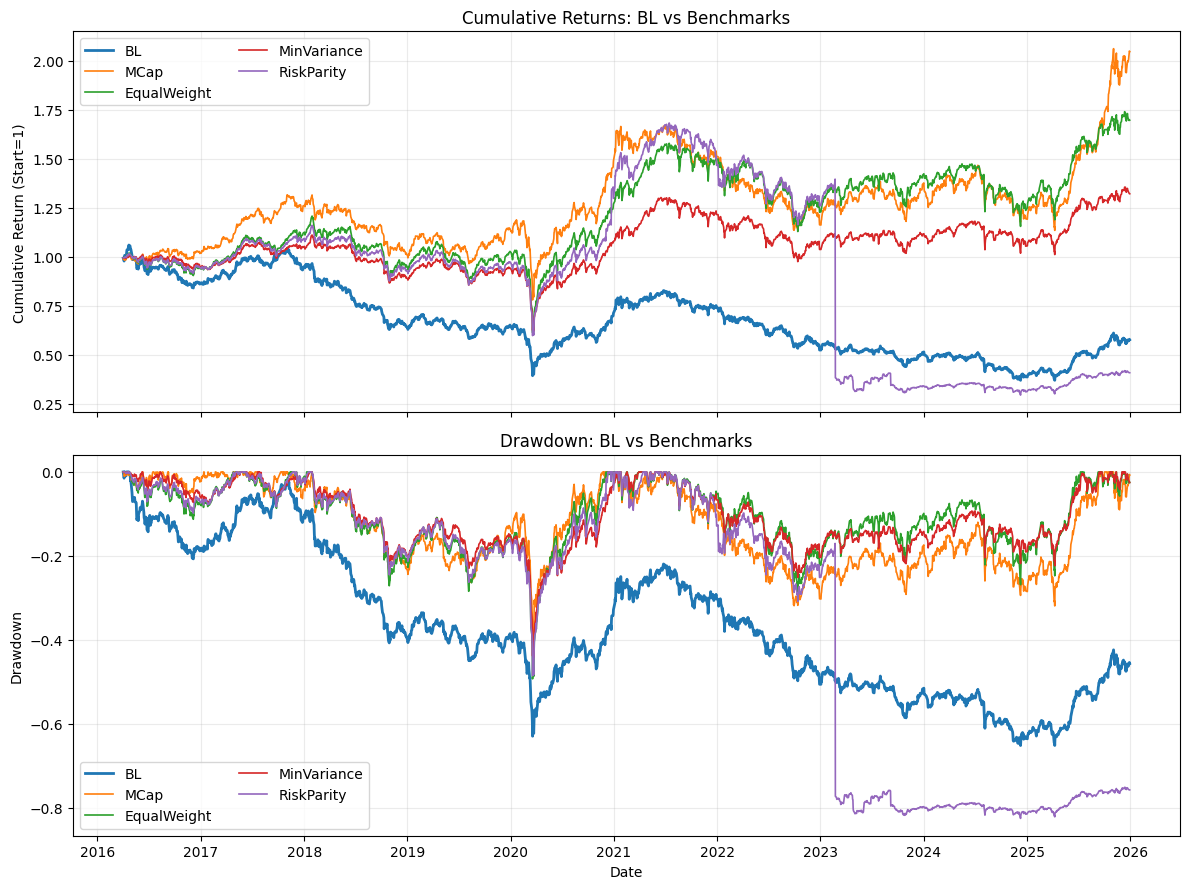

In [14]:
if "bench_daily" not in globals() or bench_daily is None or len(bench_daily) == 0:
    print("No bench_daily data. Run the rolling benchmark summary cell first.")
else:
    plot_df = bench_daily.copy()

    cols = {
        "BL": "bl_ret",
        "MCap": "mcap_ret",
        "EqualWeight": "ew_ret",
        "MinVariance": "mv_ret",
        "RiskParity": "rp_ret",
    }

    cum_df = pd.DataFrame(index=plot_df.index)
    dd_df = pd.DataFrame(index=plot_df.index)

    for name, col in cols.items():
        if col in plot_df.columns:
            s = pd.to_numeric(plot_df[col], errors="coerce").fillna(0.0)
            cum = (1.0 + s).cumprod()
            roll_max = cum.cummax()
            dd = (cum / roll_max) - 1.0

            cum_df[name] = cum
            dd_df[name] = dd

    if cum_df.empty:
        print("No valid strategy return columns found in bench_daily.")
    else:
        fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

        for c in cum_df.columns:
            lw = 2.0 if c == "BL" else 1.2
            axes[0].plot(cum_df.index, cum_df[c], label=c, linewidth=lw)

        axes[0].set_title("Cumulative Returns: BL vs Benchmarks")
        axes[0].set_ylabel("Cumulative Return (Start=1)")
        axes[0].grid(alpha=0.25)
        axes[0].legend(loc="best", ncol=2)

        for c in dd_df.columns:
            lw = 2.0 if c == "BL" else 1.2
            axes[1].plot(dd_df.index, dd_df[c], label=c, linewidth=lw)

        axes[1].set_title("Drawdown: BL vs Benchmarks")
        axes[1].set_xlabel("Date")
        axes[1].set_ylabel("Drawdown")
        axes[1].grid(alpha=0.25)
        axes[1].legend(loc="best", ncol=2)

        plt.tight_layout()
        plt.show()


# Export

In [ ]:
# Export results to a single Excel workbook (multi-sheet)
from pathlib import Path

EXPORT_PATH = Path("backtest") / "bl_daily_backtest_outputs.xlsx"
EXPORT_PATH.parent.mkdir(parents=True, exist_ok=True)


def _safe_df(x):
    return x if isinstance(x, pd.DataFrame) else pd.DataFrame()


def _safe_series(x):
    return x if isinstance(x, pd.Series) else pd.Series(dtype=float)


# 1) Config sheet
config_keys = [
    "EMBEDDING_PATH", "RETURN_PATH", "ADJ_CLOSE_PATH", "MCAP_PATH", "KOSPI_PATH", "RISK_FREE_PATH",
    "DATA_START_DATE",
    "RAW_TARGET_RETURN_COL", "TARGET_RETURN_COL", "BACKTEST_RETURN_COL",
    "WINDOW", "RIDGE_ALPHA", "MIN_TRAIN_SAMPLES", "RUN_ALPHA_SEARCH", "ALPHA_GRID", "ALPHA_SELECTION_METRIC", "MIN_REPORT_COUNT",
    "WINSOR_LOWER_Q", "WINSOR_UPPER_Q", "RISK_AVERSION", "RISK_FREE_TRADING_DAYS",
    "OMEGA_MIN_OBS", "OMEGA_FALLBACK_MSE", "OMEGA_WARMUP_DAYS",
    "MIN_COVERAGE", "TAU", "LONG_ONLY", "WEIGHT_CLIP",
    "TRANSACTION_COST_BPS", "SELL_TAX_BPS", "ANNUALIZATION",
]
config_rows = []
for k in config_keys:
    if k in globals():
        config_rows.append({"key": k, "value": globals()[k]})
config_df = pd.DataFrame(config_rows)

# 2) Ridge daily report counts (expanding-window based)
# n_train_reports_expanding: number of report rows used in ridge training block
# for each prediction date, based on all past dates up to the day before.
ridge_daily_report_count = pd.DataFrame()
if "df_model" in globals() and isinstance(df_model, pd.DataFrame) and len(df_model) > 0:
    df_tmp = df_model.dropna(subset=[TARGET_RETURN_COL]).copy()
    df_tmp["date"] = pd.to_datetime(df_tmp["date"])
    unique_dates = pd.DatetimeIndex(sorted(df_tmp["date"].unique()))

    rows = []
    if len(unique_dates) > WINDOW:
        for i in range(WINDOW, len(unique_dates)):
            pred_date = unique_dates[i]
            train_dates = unique_dates[:i]

            train_block = df_tmp.loc[df_tmp["date"].isin(train_dates)].dropna(
                subset=embedding_cols + [TARGET_RETURN_COL]
            )
            test_block = df_tmp.loc[df_tmp["date"] == pred_date].dropna(subset=embedding_cols)

            rows.append({
                "date": pred_date,
                "n_train_reports_expanding": int(len(train_block)),
                "n_test_reports_date": int(len(test_block)),
                "used_for_fit": bool((len(train_block) >= MIN_TRAIN_SAMPLES) and (len(test_block) > 0)),
            })

    ridge_daily_report_count = pd.DataFrame(rows)
    if not ridge_daily_report_count.empty:
        ridge_daily_report_count = ridge_daily_report_count.set_index("date").sort_index()

if "df_pred" in globals() and isinstance(df_pred, pd.DataFrame) and len(df_pred) > 0:
    pred_cnt = df_pred.groupby("date").size().rename("n_predicted")
    if ridge_daily_report_count.empty:
        ridge_daily_report_count = pred_cnt.to_frame()
    else:
        ridge_daily_report_count = ridge_daily_report_count.join(pred_cnt, how="left")

if not ridge_daily_report_count.empty:
    if "n_predicted" in ridge_daily_report_count.columns:
        ridge_daily_report_count["n_predicted"] = ridge_daily_report_count["n_predicted"].fillna(0).astype(int)

# 2-1) Alpha search table (optional)
alpha_grid_result = pd.DataFrame()
if "alpha_search_result" in globals() and isinstance(alpha_search_result, pd.DataFrame) and len(alpha_search_result) > 0:
    alpha_grid_result = alpha_search_result.copy()

# 3) Daily risk aversion
risk_aversion_daily = pd.DataFrame()
if "risk_df" in globals() and isinstance(risk_df, pd.DataFrame):
    risk_aversion_daily = risk_df.copy()

if not risk_aversion_daily.empty:
    risk_aversion_daily["risk_aversion"] = float(RISK_AVERSION)

if not risk_aversion_daily.empty:
    risk_aversion_daily = risk_aversion_daily.sort_index()

# 4) Backtest daily
backtest_daily = pd.DataFrame()
if "df_bt" in globals() and isinstance(df_bt, pd.DataFrame) and len(df_bt) > 0:
    backtest_daily = df_bt.copy().reset_index().rename(columns={"index": "date"})

# 4-1) Daily Omega history (expanding day-level MSE)
omega_daily = pd.DataFrame()
if "omega_daily_hist" in globals() and isinstance(omega_daily_hist, list) and len(omega_daily_hist) > 0:
    omega_daily = pd.DataFrame(omega_daily_hist)

# 5) Weights (long + requested wide)
weights_daily_long = pd.DataFrame()
weights_daily = pd.DataFrame()  # requested: index=date, columns=ticker_code, values=weight
if "weights_history" in globals() and isinstance(weights_history, pd.DataFrame) and len(weights_history) > 0:
    weights_daily_long = weights_history.copy()
    weights_daily = (
        weights_history
        .pivot_table(index="date", columns="ticker_code", values="weight", aggfunc="mean")
        .sort_index()
        .fillna(0.0)
    )

# 6) Performance summary (if available)
performance_summary = pd.DataFrame()
if "summary" in globals():
    if isinstance(summary, pd.Series):
        performance_summary = summary.to_frame(name="value")
    elif isinstance(summary, pd.DataFrame):
        performance_summary = summary.copy()

with pd.ExcelWriter(EXPORT_PATH, engine="openpyxl") as writer:
    config_df.to_excel(writer, sheet_name="config", index=False)

    if not ridge_daily_report_count.empty:
        ridge_daily_report_count.to_excel(writer, sheet_name="ridge_daily_report_count")

    if not alpha_grid_result.empty:
        alpha_grid_result.to_excel(writer, sheet_name="ridge_alpha_grid", index=False)

    if "df_pred" in globals() and isinstance(df_pred, pd.DataFrame) and len(df_pred) > 0:
        df_pred.to_excel(writer, sheet_name="ridge_predictions", index=False)

    if not risk_aversion_daily.empty:
        risk_aversion_daily.to_excel(writer, sheet_name="risk_aversion_daily")

    if not backtest_daily.empty:
        backtest_daily.to_excel(writer, sheet_name="backtest_daily", index=False)

    if not omega_daily.empty:
        omega_daily.to_excel(writer, sheet_name="omega_daily", index=False)

    if not weights_daily_long.empty:
        weights_daily_long.to_excel(writer, sheet_name="weights_daily_long", index=False)

    if not weights_daily.empty:
        weights_daily.to_excel(writer, sheet_name="weights_daily")

    if not performance_summary.empty:
        performance_summary.to_excel(writer, sheet_name="performance_summary")

print(f"saved: {EXPORT_PATH}")
